In [1]:
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import random
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense

/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
2025-08-23 07:04:37.834170: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-23 07:04:47.475121: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-23 07:04:53.256464: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been register

In [2]:
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available: 1


2025-08-23 07:05:23.871433: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-08-23 07:05:29.853713: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-08-23 07:05:29.857696: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [3]:
logdir = "tensorboard_logs/fit"
tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1)

In [4]:
#setting random seed
seed = 42 
random.seed(seed)

#setting seed for NumPy
np.random.seed(seed)

#setting seed for TensorFlow
tf.random.set_seed(seed)

#setting seed for full reproducibility (slower but stricter)
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [5]:
data_labels = pd.read_csv('dev_data_2025.csv')
data_labels.head()
print(len(data_labels['imageID']))

5000


In [6]:
image_path = "Hematoxylin/"
images = os.listdir(image_path)
print(f"Total Number of Images:{len(images)}")

Total Number of Images:10298


In [7]:
images_set = set(images)
csv_images_set = set(data_labels['imageID'].astype(str))
print("Images in labels_main but missing from patch_images folder:", len(csv_images_set - images_set))

#use only images that are listed in the CSV file
images_filtered = [img for img in images if img in csv_images_set]

Images in labels_main but missing from patch_images folder: 5000


In [8]:
"""
I have two way of loading dataset, one is on the fly using tensorflow and another is this, this one is not memeory efficient enough but makes the training faster
I will do this for now, and later i will think about usinng tensorflow one the fly process. but lets create a pipline for now.
"""



# import os
# from PIL import Image

# # 1) Build a filename column that exactly matches what’s on disk
data_labels['filename'] = data_labels['imageID'].astype(str) + ".jpg"
data_labels['full_path'] = data_labels['filename'].apply(lambda x: os.path.join(image_path, x))

# # 2) Loader returns a dict keyed by *filename* (with extension)
# def load_images(image_folder, filenames):
#     images = {}
#     for fname in filenames:
#         img_path = os.path.join(image_folder, fname)
#         try:
#             with Image.open(img_path) as img:
#                 images[fname] = img.copy()
#         except Exception as e:
#             print(f"Error loading {fname}: {e}")
#     return images

# # 3) Load using the filename column, then map with the same key
# image_objects = load_images(image_path, data_labels['filename'])
# data_labels['Image'] = data_labels['filename'].map(image_objects)


In [9]:
print(data_labels.head())

     imageID       label cell_shape         nucleus_shape cytoplasm_vacuole  \
0  Img_00001  Lymphocyte      round     unsegmented-round                no   
1  Img_00002    Monocyte  irregular  unsegmented-indented                no   
2  Img_00003    Monocyte  irregular             irregular               yes   
3  Img_00004    Basophil      round  segmented-multilobed                no   
4  Img_00005  Neutrophil      round      unsegmented-band                no   

        filename                  full_path  
0  Img_00001.jpg  Hematoxylin/Img_00001.jpg  
1  Img_00002.jpg  Hematoxylin/Img_00002.jpg  
2  Img_00003.jpg  Hematoxylin/Img_00003.jpg  
3  Img_00004.jpg  Hematoxylin/Img_00004.jpg  
4  Img_00005.jpg  Hematoxylin/Img_00005.jpg  


In [10]:
data_labels.iloc[900:]

,imageID,label,cell_shape,nucleus_shape,cytoplasm_vacuole,filename,full_path
900,Img_00901,Lymphocyte,round,unsegmented-round,no,Img_00901.jpg,Hematoxylin/Img_00901.jpg
901,Img_00902,Neutrophil,round,unsegmented-band,no,Img_00902.jpg,Hematoxylin/Img_00902.jpg
902,Img_00903,Neutrophil,round,unsegmented-band,no,Img_00903.jpg,Hematoxylin/Img_00903.jpg
903,Img_00904,Eosinophil,round,segmented-bilobed,no,Img_00904.jpg,Hematoxylin/Img_00904.jpg
904,Img_00905,Monocyte,irregular,unsegmented-round,yes,Img_00905.jpg,Hematoxylin/Img_00905.jpg
...,...,...,...,...,...,...,...
4995,Img_04996,Lymphocyte,irregular,unsegmented-round,no,Img_04996.jpg,Hematoxylin/Img_04996.jpg
4996,Img_04997,Neutrophil,round,unsegmented-band,no,Img_04997.jpg,Hematoxylin/Img_04997.jpg
4997,Img_04998,Basophil,round,irregular,no,Img_04998.jpg,Hematoxylin/Img_04998.jpg
4998,Img_04999,Neutrophil,round,unsegmented-band,no,Img_04999.jpg,Hematoxylin/Img_04999.jpg


In [11]:
data_labels.shape

(5000, 7)

In [12]:
data_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   imageID            5000 non-null   object
 1   label              5000 non-null   object
 2   cell_shape         5000 non-null   object
 3   nucleus_shape      5000 non-null   object
 4   cytoplasm_vacuole  5000 non-null   object
 5   filename           5000 non-null   object
 6   full_path          5000 non-null   object
dtypes: object(7)
memory usage: 273.6+ KB


## EDA

In [13]:
print("Total samples:", len(data_labels))
print("\nMissing values:\n", data_labels.isnull().sum())
print("\nUnique labels per column:")
for col in ['label', 'cell_shape', 'nucleus_shape', 'cytoplasm_vacuole']:
    print(f"{col}: {data_labels[col].unique()}")


Total samples: 5000

Missing values:
 imageID              0
label                0
cell_shape           0
nucleus_shape        0
cytoplasm_vacuole    0
filename             0
full_path            0
dtype: int64

Unique labels per column:
label: ['Lymphocyte' 'Monocyte' 'Basophil' 'Neutrophil' 'Eosinophil']
cell_shape: ['round' 'irregular']
nucleus_shape: ['unsegmented-round' 'unsegmented-indented' 'irregular'
 'segmented-multilobed' 'unsegmented-band' 'segmented-bilobed']
cytoplasm_vacuole: ['no' 'yes']


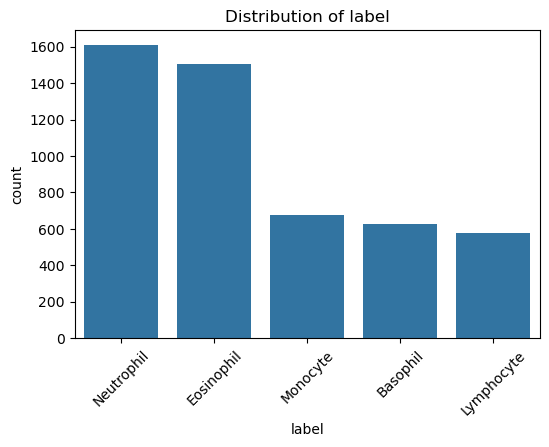

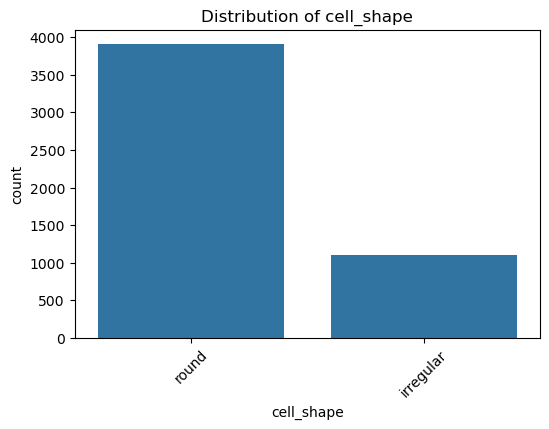

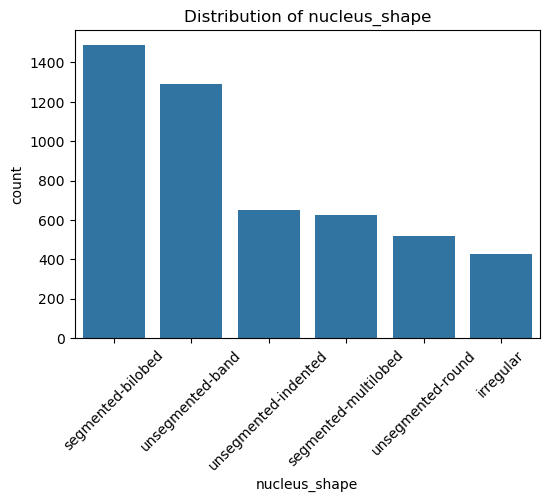

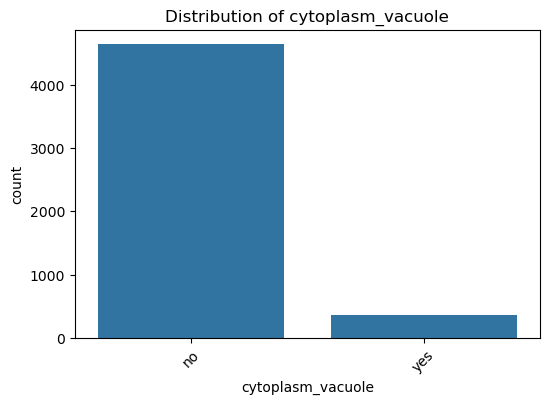

In [14]:
"""
class balance check, neutrophil and eosinophil has more distribution than other, have to take care of this.
round type shape is more
segmented and unsegmented is more
in cytoplasm vacuole, no has more data
"""

import seaborn as sns
import matplotlib.pyplot as plt

categorical_cols = ['label', 'cell_shape', 'nucleus_shape', 'cytoplasm_vacuole']

for col in categorical_cols:
    plt.figure(figsize=(6,4))
    sns.countplot(data=data_labels, x=col, order=data_labels[col].value_counts().index)
    plt.title(f"Distribution of {col}")
    plt.xticks(rotation=45)
    plt.show()


In [15]:
# sizes = data_labels['Image'].apply(lambda img: img.size)
# print("Unique image shape and size:", sizes.value_counts())


from PIL import Image
from collections import Counter

size_counts = Counter()
for path in data_labels['full_path']:
    with Image.open(path) as img:
        size_counts[img.size] += 1

print("Unique image sizes and counts:", size_counts)


Unique image sizes and counts: Counter({(360, 363): 4875, (366, 369): 125})


In [16]:
import numpy as np
sample_path = data_labels['full_path'].iloc[0]
with Image.open(sample_path) as img:
    arr = np.array(img)
print("Pixel range:", arr.min(), "-", arr.max())
print("Shape:", arr.shape)


Pixel range: 24 - 255
Shape: (363, 360, 3)


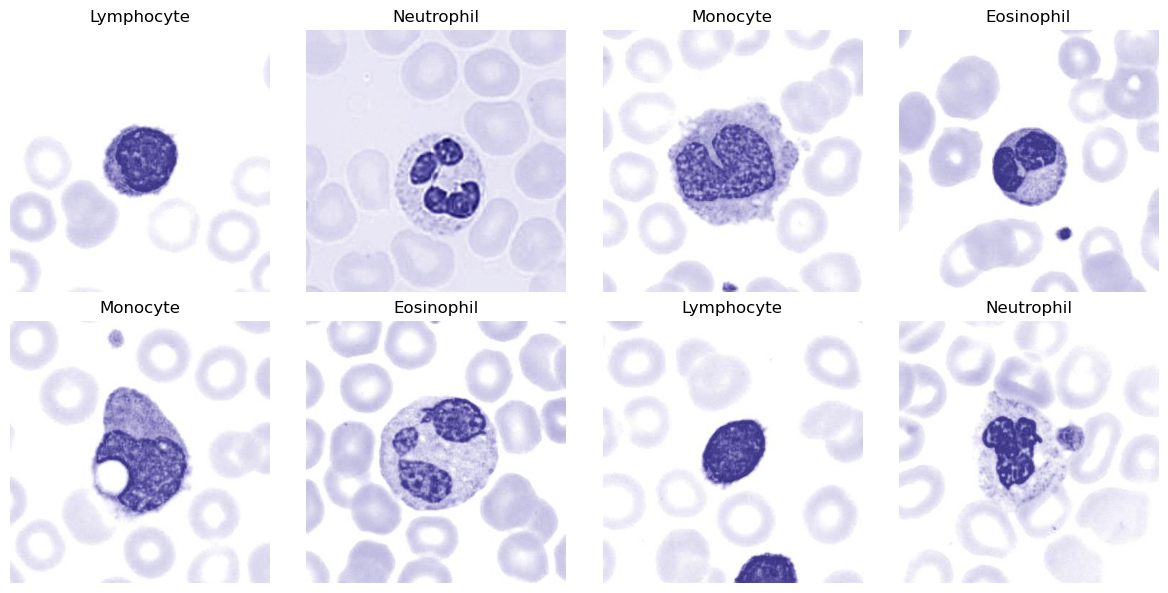

In [17]:
from random import sample

sample_paths = sample(list(data_labels['full_path']), 8)
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for ax, path in zip(axes.flat, sample_paths):
    with Image.open(path) as img:
        ax.imshow(img)
    label = data_labels.loc[data_labels['full_path'] == path, 'label'].values[0]
    ax.set_title(label)
    ax.axis('off')
plt.tight_layout()
plt.show()


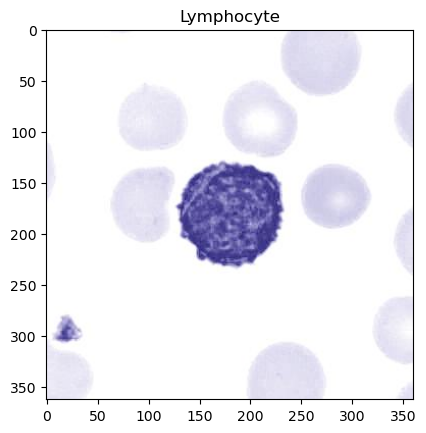

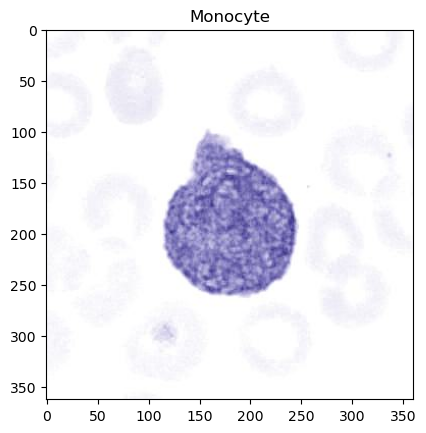

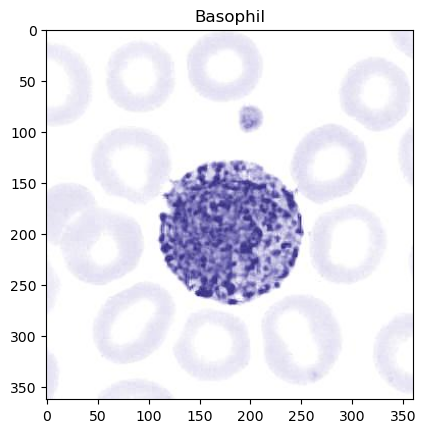

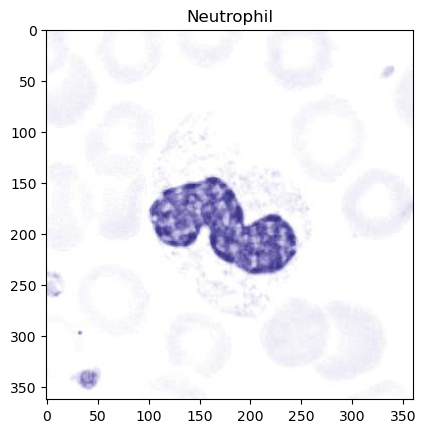

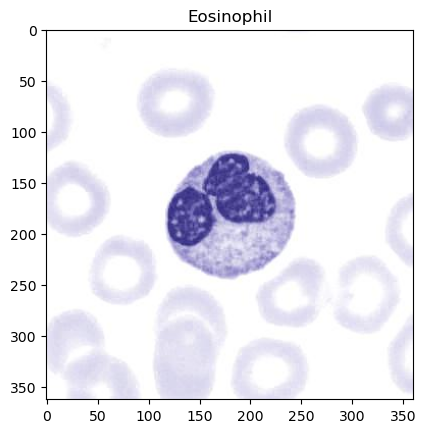

In [18]:
for cls in data_labels['label'].unique():
    sample_path = data_labels[data_labels['label'] == cls]['full_path'].sample(1).iloc[0]
    with Image.open(sample_path) as img:
        plt.imshow(img)
        plt.title(cls)
        plt.show()


In [19]:
# import numpy as np
# sample_img = np.array(data_labels['Image'].iloc[0])
# print("Pixel range:", sample_img.min(), "-", sample_img.max())
# print("Shape:", sample_img.shape)


In [20]:
# from random import sample

# fig, axes = plt.subplots(2, 4, figsize=(12, 6))
# for ax, idx in zip(axes.flat, sample(range(len(data_labels)), 8)):
#     img = data_labels['Image'].iloc[idx]
#     label = data_labels['label'].iloc[idx]
#     ax.imshow(img)
#     ax.set_title(label)
#     ax.axis('off')
# plt.tight_layout()
# plt.show()


## Data loading, Merging with images preparing for training

In [21]:
# import numpy as np
# import pandas as pd
# import tensorflow as tf

# TARGET_SIZE = (224, 224)  # good for transfer learning
# BATCH_SIZE  = 32
# AUTOTUNE    = tf.data.AUTOTUNE

# # Use pandas' Categorical to encode string labels → ints (stable & simple)
# for col in ['label', 'cell_shape', 'nucleus_shape', 'cytoplasm_vacuole']:
#     data_labels[col] = pd.Categorical(data_labels[col])
#     data_labels[col + '_idx'] = data_labels[col].cat.codes  # int labels starting at 0

# # Keep mapping dicts for later decoding (nice for reports/confusion matrices)
# idx2label = {i: c for i, c in enumerate(data_labels['label'].cat.categories)}
# idx2cell  = {i: c for i, c in enumerate(data_labels['cell_shape'].cat.categories)}
# idx2nuc   = {i: c for i, c in enumerate(data_labels['nucleus_shape'].cat.categories)}
# idx2vac   = {i: c for i, c in enumerate(data_labels['cytoplasm_vacuole'].cat.categories)}

# n_label = len(idx2label)
# n_cell  = len(idx2cell)
# n_nuc   = len(idx2nuc)
# n_vac   = len(idx2vac)

# print(n_label, n_cell, n_nuc, n_vac)




from sklearn.preprocessing import LabelEncoder



TARGET_SIZE = (224, 224)  # good for transfer learning
BATCH_SIZE  = 32
AUTOTUNE    = tf.data.AUTOTUNE

label_encoder = LabelEncoder()
cell_encoder  = LabelEncoder()
nuc_encoder   = LabelEncoder()
vac_encoder   = LabelEncoder()

data_labels['label_idx'] = label_encoder.fit_transform(data_labels['label'])
data_labels['cell_shape_idx'] = cell_encoder.fit_transform(data_labels['cell_shape'])
data_labels['nucleus_shape_idx'] = nuc_encoder.fit_transform(data_labels['nucleus_shape'])
data_labels['cytoplasm_vacuole_idx'] = vac_encoder.fit_transform(data_labels['cytoplasm_vacuole'])

# Store category names
n_label = len(label_encoder.classes_)
n_cell  = len(cell_encoder.classes_)
n_nuc   = len(nuc_encoder.classes_)
n_vac   = len(vac_encoder.classes_)

print(n_label, n_cell, n_nuc, n_vac)

5 2 6 2


In [22]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(
    data_labels,
    test_size=0.2,
    random_state=42,
    stratify=data_labels['label_idx']  # stratify on main class
)

len(train_df), len(val_df)


(4000, 1000)

In [23]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

rng = 42
val_df = val_df.copy()  # just in case

# ---- 1) build a small EYEBALL set: per-class k samples ----
per_class = 10  # tweak: 8–12 is typical
eyeball_idx = []

for cls, group in val_df.groupby('label_idx'):
    take = group.sample(n=min(per_class, len(group)), random_state=rng).index
    eyeball_idx.append(take)

eyeball_idx = np.concatenate(eyeball_idx) if len(eyeball_idx) else np.array([], dtype=int)
eyeball_df  = val_df.loc[eyeball_idx].copy()

# remaining = blackbox candidate pool
blackbox_pool = val_df.drop(index=eyeball_idx)

# ---- 2) optionally keep blackbox to a fixed fraction of the whole val ----
# e.g., use all remaining (recommended) or take a fraction stratified
# here we keep ALL remaining:
blackbox_df = blackbox_pool.copy()

print({
    "eyeball_dev": len(eyeball_df),
    "blackbox_dev": len(blackbox_df)
})

# quick sanity
print("Eyeball per class:\n", eyeball_df['label'].value_counts())
print("Blackbox per class:\n", blackbox_df['label'].value_counts())


{'eyeball_dev': 50, 'blackbox_dev': 950}
Eyeball per class:
 label
Basophil      10
Eosinophil    10
Lymphocyte    10
Monocyte      10
Neutrophil    10
Name: count, dtype: int64
Blackbox per class:
 label
Neutrophil    312
Eosinophil    291
Monocyte      126
Basophil      115
Lymphocyte    106
Name: count, dtype: int64


In [24]:
def load_and_preprocess(path, y_label, y_cell, y_nuc, y_vac):
    # path: tf.string, labels: tf.int32
    img = tf.io.read_file(path)
    # use decode_jpeg or decode_image (handles png/jpg). You have .jpg, so:
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, TARGET_SIZE)
    img = tf.cast(img, tf.float32) / 255.0
    # img = tf.cast(img, tf.float32)

    # Optionally do light augmentation for training via a separate map
    labels = {
        'out_label': tf.one_hot(y_label, depth=n_label),
        'out_cell':  tf.one_hot(y_cell,  depth=n_cell),
        'out_nuc':   tf.one_hot(y_nuc,   depth=n_nuc),
        'out_vac':   tf.one_hot(y_vac,   depth=n_vac),
    }
    return img, labels

def make_dataset(df, shuffle=False, augment=False, repeat=False):
    paths = df['full_path'].astype(str).values
    y_label = df['label_idx'].values.astype(np.int32)
    y_cell  = df['cell_shape_idx'].values.astype(np.int32)
    y_nuc   = df['nucleus_shape_idx'].values.astype(np.int32)
    y_vac   = df['cytoplasm_vacuole_idx'].values.astype(np.int32)

    ds = tf.data.Dataset.from_tensor_slices((paths, y_label, y_cell, y_nuc, y_vac))

    if shuffle:
        ds = ds.shuffle(buffer_size=min(len(df), 2000), seed=42)

    ds = ds.map(load_and_preprocess, num_parallel_calls=AUTOTUNE)

    if augment:
        aug = tf.keras.Sequential([
            tf.keras.layers.RandomFlip('horizontal'),
            tf.keras.layers.RandomRotation(0.05),
            tf.keras.layers.RandomZoom(0.05),
            # tf.keras.layers.RandomBrightness(factor=0.1),
            tf.keras.layers.RandomBrightness(factor=0.1, value_range=(0.0, 1.0)),
            # tf.keras.layers.Rescaling(1./255),
        ])
        ds = ds.map(lambda x, y: (aug(x, training=True), y), num_parallel_calls=AUTOTUNE)

    ds = ds.batch(BATCH_SIZE)
    if repeat:
        ds = ds.repeat()

    ds = ds.prefetch(AUTOTUNE)
    return ds


train_ds    = make_dataset(train_df, shuffle=True, augment=True, repeat=True)     # repeated
eyeball_ds  = make_dataset(eyeball_df, shuffle=False, augment=False, repeat=False) # NOT repeated
blackbox_ds = make_dataset(blackbox_df, shuffle=False, augment=False, repeat=False) # NOT repeated



2025-08-23 07:05:35.302376: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-08-23 07:05:35.306327: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-08-23 07:05:35.309130: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [25]:
for imgs, labels in train_ds.take(1):
    print("imgs:", imgs.shape, imgs.dtype, tf.reduce_min(imgs).numpy(), tf.reduce_max(imgs).numpy())
    for k, v in labels.items():
        v = tf.cast(v, tf.float32)
        print(k, v.shape, "one-hot sums per row ~1:",
              tf.reduce_mean(tf.reduce_sum(v, axis=1)).numpy())


imgs: (32, 224, 224, 3) <dtype: 'float32'> 0.09586757 1.0
out_label (32, 5) one-hot sums per row ~1: 1.0
out_cell (32, 2) one-hot sums per row ~1: 1.0
out_nuc (32, 6) one-hot sums per row ~1: 1.0
out_vac (32, 2) one-hot sums per row ~1: 1.0


2025-08-23 07:05:51.811872: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


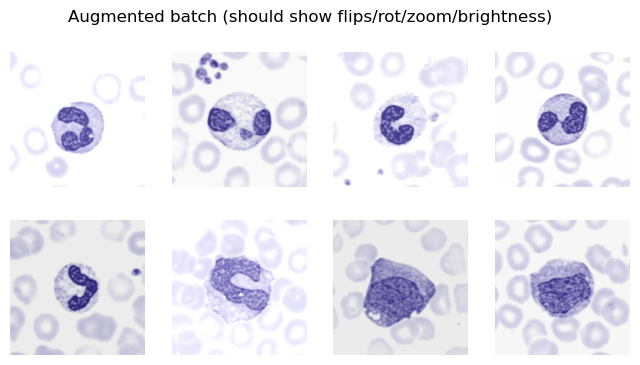

2025-08-23 07:05:52.432209: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [26]:
import matplotlib.pyplot as plt

def show_batch(imgs, rows=2, cols=4, title=""):
    imgs = imgs.numpy()
    plt.figure(figsize=(cols*2, rows*2))
    for i in range(min(len(imgs), rows*cols)):
        ax = plt.subplot(rows, cols, i+1)
        ax.imshow(imgs[i])
        ax.axis('off')
    if title: plt.suptitle(title)
    plt.show()

for imgs, labels in train_ds.take(1):
    show_batch(imgs, title="Augmented batch (should show flips/rot/zoom/brightness)")


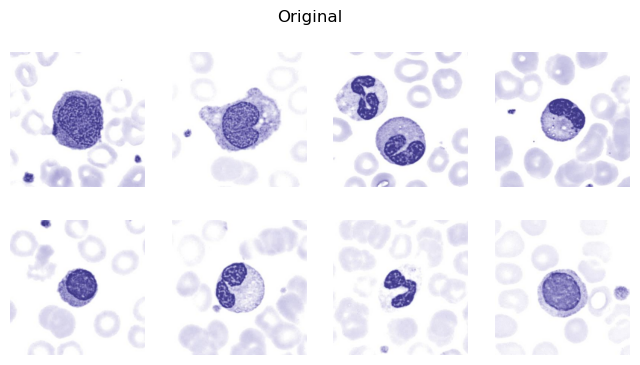

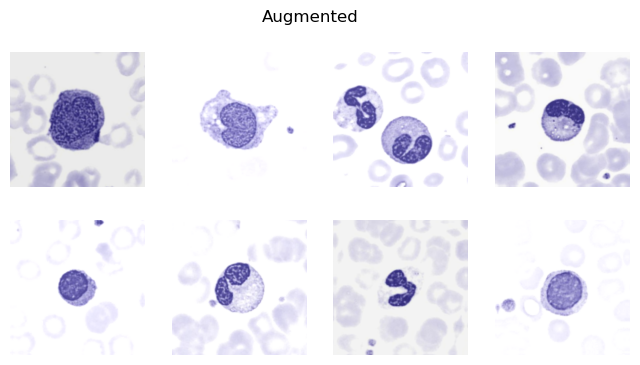

Per-image mean abs diffs: [0.10051125 0.04381777 0.08996662 0.07286356 0.03985592 0.04534821
 0.0601581  0.03778525]


In [27]:
subset = train_df.sample(8, random_state=123)

noaug = make_dataset(subset, shuffle=False, augment=False, repeat=False)
aug   = make_dataset(subset, shuffle=False, augment=True,  repeat=False)

paired = tf.data.Dataset.zip((noaug, aug)).take(1)
(orig_imgs, _), (aug_imgs, _) = next(iter(paired))

show_batch(orig_imgs, title="Original")
show_batch(aug_imgs,  title="Augmented")

# Quantify difference per image (should be >0 for most)
diff = tf.reduce_mean(tf.abs(tf.cast(orig_imgs, tf.float32) - tf.cast(aug_imgs, tf.float32)), axis=[1,2,3])
print("Per-image mean abs diffs:", diff.numpy())


In [28]:
xb, yb = next(iter(train_ds))
print("Batch images:", xb.shape)  # (B, 224, 224, 3)
for k, v in yb.items():
    print(k, v.shape)             # one-hot shapes per head


Batch images: (32, 224, 224, 3)
out_label (32, 5)
out_cell (32, 2)
out_nuc (32, 6)
out_vac (32, 2)


In [29]:
# from tensorflow.keras import layers, models, applications

# base = applications.EfficientNetB0(include_top=False, input_shape=(224,224,3), weights='imagenet')
# base.trainable = False  # warm-up; later unfreeze some blocks

# x = layers.GlobalAveragePooling2D()(base.output)
# x = layers.Dropout(0.3)(x)  # your identifiable, tunable block

# # 4 heads
# out_label = layers.Dense(n_label, activation='softmax', name='out_label')(x)
# out_cell  = layers.Dense(n_cell,  activation='softmax', name='out_cell')(x)
# out_nuc   = layers.Dense(n_nuc,   activation='softmax', name='out_nuc')(x)
# out_vac   = layers.Dense(n_vac,   activation='softmax', name='out_vac')(x)

# model = models.Model(inputs=base.input, outputs=[out_label, out_cell, out_nuc, out_vac])

# model.compile(
#     optimizer=tf.keras.optimizers.Adam(1e-3),
#     loss={
#         'out_label': 'categorical_crossentropy',
#         'out_cell':  'categorical_crossentropy',
#         'out_nuc':   'categorical_crossentropy',
#         'out_vac':   'categorical_crossentropy',
#     },
#     loss_weights={'out_label': 1.0, 'out_cell': 0.7, 'out_nuc': 0.7, 'out_vac': 0.7},
#     metrics={k: ['accuracy'] for k in ['out_label','out_cell','out_nuc','out_vac']}
# )

# model.summary()


In [30]:
# history = model.fit(
#     train_ds,
#     validation_data=blackbox_ds,
#     epochs=10,
#     # class_weight applies to ONE output; simplest is omit here for now,
#     # or train main head separately if you must apply per-class weighting.
# )


In [31]:
import tensorflow as tf

class WbcModel(tf.keras.Model):
    def __init__(self, num_classes = 4):
        super().__init__()

        #layer1
        self.conv1 = tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu')
        self.pool1 = tf.keras.layers.MaxPool2D(pool_size=2, strides=2)

        #layer2
        self.conv2 = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu')
        self.pool2 = tf.keras.layers.MaxPool2D(pool_size=2, strides=2)

        #Layer3
        self.conv3 = tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu')
        self.pool3 = tf.keras.layers.MaxPool2D(pool_size=2, strides=2)

         #Layer4
        self.conv4 = tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu')
        self.pool4 = tf.keras.layers.MaxPool2D(pool_size=2, strides=2)


        #Regularization
        self.drop = tf.keras.layers.Dropout(0.25)

        #Head, 4 for this problem
        # self.flat = tf.keras.layers.Flatten()

        self.gap = tf.keras.layers.GlobalAveragePooling2D()

        
        self.out_label = tf.keras.layers.Dense(n_label, activation='softmax',name='out_label')
        self.out_cell = tf.keras.layers.Dense(n_cell, activation='softmax',name='out_cell')
        self.out_nuc = tf.keras.layers.Dense(n_nuc,activation='softmax',name='out_nuc')
        self.out_vac = tf.keras.layers.Dense(n_vac,activation='softmax',name='out_vac')

    def call(self,x, training=False):
        x = self.conv1(x); x = self.pool1(x)
        x = self.conv2(x); x = self.pool2(x)
        x = self.conv3(x); x = self.pool3(x)
        x = self.conv4(x); x = self.pool4(x)
        

        if training:
            x = self.drop(x)

        # x = self.flat(x)
        x = self.gap(x)

        if training:
            x = self.drop(x)

        return {
            "out_label": self.out_label(x),
            "out_cell":  self.out_cell(x),
            "out_nuc":   self.out_nuc(x),
            "out_vac":   self.out_vac(x)
        }

model = WbcModel(num_classes=4)

model.build(input_shape=(None,224,224,3))
model.summary()
        

        

Model: "wbc_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  896       
                                                                 
 max_pooling2d (MaxPooling2  multiple                  0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           multiple                  18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  multiple                  0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           multiple                  73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  multiple                  0 

In [32]:
# model.compile(
#     optimizer=tf.keras.optimizers.Adam(1e-3),
#     loss={
#         'out_label': 'categorical_crossentropy',
#         'out_cell':  'categorical_crossentropy',
#         'out_nuc':   'categorical_crossentropy',
#         'out_vac':   'categorical_crossentropy',
#     },
#     loss_weights={'out_label': 1.0, 'out_cell': 0.7, 'out_nuc': 0.7, 'out_vac': 0.7},
#     metrics={k: ['accuracy'] for k in ['out_label','out_cell','out_nuc','out_vac']}
# )

In [33]:
# BATCH_SIZE = 32
N_TRAIN = len(train_df)

MAX_EPOCH = 100

STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.001,
    decay_steps=STEPS_PER_EPOCH*1000,
    decay_rate =1,
    staircase=False
)


In [34]:
print(N_TRAIN)

4000


In [35]:
# from pathlib import Path

# def get_callbacks(name):
#     logdir = Path("logs") / name
#     return [
#         tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20),
#         tf.keras.callbacks.TensorBoard(log_dir=str(logdir))
#     ]



from pathlib import Path
import json, tensorflow as tf

def get_callbacks(name, params=None):
    logdir = Path("logs") / name
    run_dir = Path("runs") / name
    run_dir.mkdir(parents=True, exist_ok=True)

    # save training params
    if params:
        with open(run_dir / "params.json", "w") as f:
            json.dump(params, f, indent=2)

    return [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=20,
            restore_best_weights=True
        ),
        tf.keras.callbacks.TensorBoard(log_dir=str(logdir)),
        tf.keras.callbacks.CSVLogger(str(run_dir / "history.csv"), append=False),
        tf.keras.callbacks.ModelCheckpoint(
            filepath=str(run_dir / "best.weights"),
            monitor="val_loss",
            mode="min",
            save_best_only=True,
            save_weights_only=True  # <- important for subclassed models
        ),
    ]






In [36]:
# def compile_and_fit(model,name, optimizer=None, max_epochs=MAX_EPOCH):
#     if optimizer is None:
#         optimizer=tf.keras.optimizers.Adam(lr_schedule)
        
#     model.compile(
#     optimizer=optimizer,
#     loss={
#         'out_label': 'categorical_crossentropy',
#         'out_cell':  'categorical_crossentropy',
#         'out_nuc':   'categorical_crossentropy',
#         'out_vac':   'categorical_crossentropy',
#     },
#     loss_weights={'out_label': 1.0, 'out_cell': 0.7, 'out_nuc': 0.7, 'out_vac': 0.7},
#     metrics={k: ['accuracy'] for k in ['out_label','out_cell','out_nuc','out_vac']}
#     )
#     # model.summary()

#     history = model.fit(
#         train_ds,
#         steps_per_epoch = STEPS_PER_EPOCH,
#         epochs = max_epochs,
#         validation_data = blackbox_ds,
#         callbacks=get_callbacks(name),
#         verbose=1
    
#     )
#     return history




from pathlib import Path
import tensorflow as tf
import time


def _lr_value(opt):
    try:
        lr = opt.learning_rate
        return float(tf.keras.backend.get_value(lr(0))) if callable(lr) else float(tf.keras.backend.get_value(lr))
    except:
        return None

def compile_and_fit(model, name, optimizer=None, max_epochs=MAX_EPOCH):
    if "%TIME%" in name:
        name = name.replace("%TIME%", time.strftime("%Y%m%d-%H%M%S"))

    if optimizer is None:
        optimizer = tf.keras.optimizers.Adam(lr_schedule)

    model.compile(
        optimizer=optimizer,
        loss={
            'out_label': 'categorical_crossentropy',
            'out_cell':  'categorical_crossentropy',
            'out_nuc':   'categorical_crossentropy',
            'out_vac':   'categorical_crossentropy',
        },
        loss_weights={'out_label': 1.0, 'out_cell': 0.7, 'out_nuc': 0.7, 'out_vac': 0.7},
        metrics={k: ['accuracy'] for k in ['out_label','out_cell','out_nuc','out_vac']}
    )

    params = {
        "epochs": int(max_epochs),
        "steps_per_epoch": int(STEPS_PER_EPOCH),
        "optimizer": optimizer.__class__.__name__,
        "learning_rate": _lr_value(optimizer),
        "loss_weights": {'out_label': 1.0, 'out_cell': 0.7, 'out_nuc': 0.7, 'out_vac': 0.7},
    }

    history = model.fit(
        train_ds,
        steps_per_epoch=STEPS_PER_EPOCH,
        epochs=max_epochs,
        validation_data=blackbox_ds,
        callbacks=get_callbacks(name, params),
        verbose=1
    )

    # save final weights (robust, always works)
    run_dir = Path("runs") / name
    run_dir.mkdir(parents=True, exist_ok=True)
    model.save_weights(run_dir / "final.weights")

    return history

        

In [37]:
history = compile_and_fit(model,'wbc_run_%TIME%')

Epoch 1/100


2025-08-23 07:06:05.271681: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inwbc_model/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-08-23 07:06:06.500088: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1755932769.798517   14342 service.cc:145] XLA service 0x7efd798db9e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755932769.798552   14342 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2025-08-23 07:06:09.956811: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1755932770.378769   14343 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the p

125/125 [==============================] - 74s 427ms/step - loss: 3.2792 - out_cell_loss: 0.5356 - out_label_loss: 1.5214 - out_nuc_loss: 1.7009 - out_vac_loss: 0.2746 - out_cell_accuracy: 0.7782 - out_label_accuracy: 0.3065 - out_nuc_accuracy: 0.2795 - out_vac_accuracy: 0.9230 - val_loss: 3.2111 - val_out_cell_loss: 0.5199 - val_out_label_loss: 1.5053 - val_out_nuc_loss: 1.6727 - val_out_vac_loss: 0.2444 - val_out_cell_accuracy: 0.7842 - val_out_label_accuracy: 0.3063 - val_out_nuc_accuracy: 0.3084 - val_out_vac_accuracy: 0.9337
Epoch 2/100
125/125 [==============================] - 52s 418ms/step - loss: 3.2330 - out_cell_loss: 0.5294 - out_label_loss: 1.5041 - out_nuc_loss: 1.6865 - out_vac_loss: 0.2540 - out_cell_accuracy: 0.7805 - out_label_accuracy: 0.3310 - out_nuc_accuracy: 0.2880 - out_vac_accuracy: 0.9273 - val_loss: 3.1311 - val_out_cell_loss: 0.5107 - val_out_label_loss: 1.4589 - val_out_nuc_loss: 1.6555 - val_out_vac_loss: 0.2228 - val_out_cell_accuracy: 0.7842 - val_out_l

In [38]:
model.save("WBCmodel_1")

INFO:tensorflow:Assets written to: WBCmodel_1/assets


INFO:tensorflow:Assets written to: WBCmodel_1/assets


In [39]:
# import tensorflow as tf
# model = tf.keras.models.load_model("WBCmodel_1.keras")

In [40]:
# history = model.fit(
#     train_ds,
#     validation_data=blackbox_ds,
#     epochs=10,
#     # class_weight applies to ONE output; simplest is omit here for now,
#     # or train main head separately if you must apply per-class weighting.
# )

In [41]:
# history = compile_and_fit(model, name="WBCmodel_1", max_epochs=MAX_EPOCH)

In [42]:
# import matplotlib.pyplot as plt

# def plot_history(history):
#     h = history.history  # dict of lists

#     # 1) ACCURACY (train vs val) for all heads
#     plt.figure()
#     for head in ["out_label", "out_cell", "out_nuc", "out_vac"]:
#         acc_key = f"{head}_accuracy"
#         val_acc_key = f"val_{head}_accuracy"
#         if acc_key in h and val_acc_key in h:
#             plt.plot(h[acc_key], label=f"{head} acc")
#             plt.plot(h[val_acc_key], linestyle='--', label=f"val {head} acc")
#     plt.title("Per-head Accuracy")
#     plt.xlabel("Epoch")
#     plt.ylabel("Accuracy")
#     plt.legend()
#     plt.grid(True)
#     plt.show()

#     # 2) LOSS (train vs val) for all heads
#     plt.figure()
#     for head in ["out_label", "out_cell", "out_nuc", "out_vac"]:
#         loss_key = f"{head}_loss"
#         val_loss_key = f"val_{head}_loss"
#         if loss_key in h and val_loss_key in h:
#             plt.plot(h[loss_key], label=f"{head} loss")
#             plt.plot(h[val_loss_key], linestyle='--', label=f"val {head} loss")
#     # also show total loss for context if present
#     if "loss" in h: plt.plot(h["loss"], label="total loss")
#     if "val_loss" in h: plt.plot(h["val_loss"], linestyle='--', label="val total loss")

#     plt.title("Per-head Loss (and Total)")
#     plt.xlabel("Epoch")
#     plt.ylabel("Loss")
#     plt.legend()
#     plt.grid(True)
#     plt.show()




import re, matplotlib.pyplot as plt

def plot_history(history, save_dir=None):
    h = history.history

    # discover heads from keys like "out_label_accuracy", "out_label_loss"
    heads = sorted({m.group(1) for k in h.keys()
                    if (m := re.match(r'^(out_[^_]+)_(accuracy|loss)$', k))})

    # --- Accuracy ---
    plt.figure()
    for head in heads:
        acc_key = f"{head}_accuracy"
        val_key = f"val_{head}_accuracy"
        if acc_key in h: plt.plot(h[acc_key], label=f"{head} acc")
        if val_key in h: plt.plot(h[val_key], linestyle='--', label=f"val {head} acc")
    plt.title("Per-head Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    if save_dir: plt.savefig(f"{save_dir}/acc.png", dpi=150, bbox_inches='tight')
    plt.show()

    # --- Loss (per head + total) ---
    plt.figure()
    for head in heads:
        loss_key = f"{head}_loss"
        val_loss_key = f"val_{head}_loss"
        if loss_key in h: plt.plot(h[loss_key], label=f"{head} loss")
        if val_loss_key in h: plt.plot(h[val_loss_key], linestyle='--', label=f"val {head} loss")
    if "loss" in h: plt.plot(h["loss"], label="total loss")
    if "val_loss" in h: plt.plot(h["val_loss"], linestyle='--', label="val total loss")
    plt.title("Per-head Loss (and Total)")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    if save_dir: plt.savefig(f"{save_dir}/loss.png", dpi=150, bbox_inches='tight')
    plt.show()

    # --- (Optional) Learning rate if ReduceLROnPlateau/SGD schedules add 'lr' ---
    if "lr" in h:
        plt.figure()
        plt.plot(h["lr"])
        plt.title("Learning Rate")
        plt.xlabel("Epoch")
        plt.ylabel("lr")
        plt.grid(True)
        if save_dir: plt.savefig(f"{save_dir}/lr.png", dpi=150, bbox_inches='tight')
        plt.show()


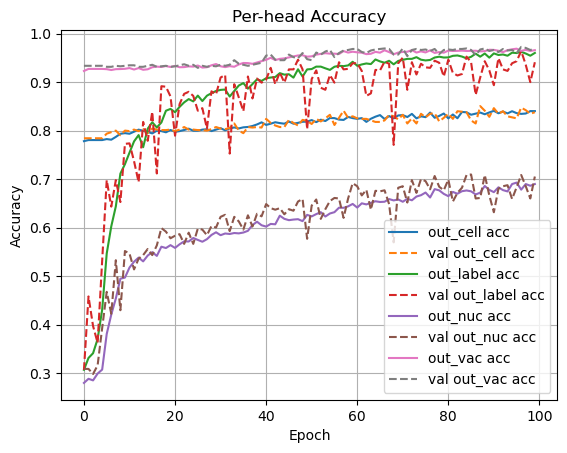

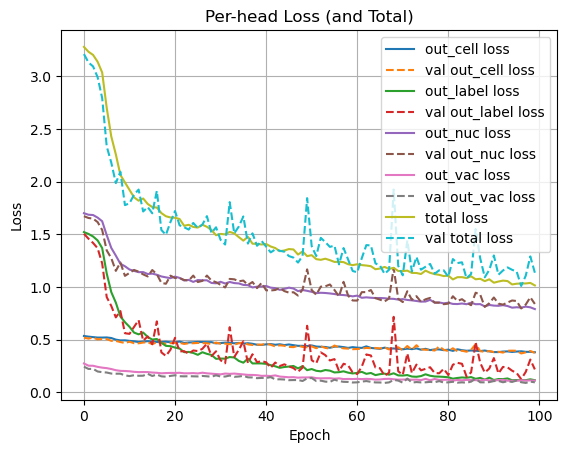

In [43]:
plot_history(history)

In [44]:
# %load_ext tensorboard
# %tensorboard --logdir tensorboard_logs/fit

In [45]:
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf

def inspect_prediction(df, index=0):
    """
    Visualize and inspect model prediction vs ground truth for a single sample from the given dataframe.

    Args:
        df (pd.DataFrame): DataFrame containing columns 'full_path', 'label', etc.
        index (int): Index of the row in df to inspect.
    """
    sample = df.iloc[index]
    img_path = sample['full_path']
    
    # Load and display the image
    img_raw = Image.open(img_path)
    plt.imshow(img_raw)
    plt.axis('off')
    plt.title(f"Ground Truth: {sample['label']}")
    plt.show()
    
    # Preprocess like the training pipeline
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, TARGET_SIZE)
    img = tf.cast(img, tf.float32) / 255.0
    img = tf.expand_dims(img, axis=0)  # model expects batch dim
    
    # Predict
    pred = model.predict(img)

    # Decode predictions
    pred_label = label_encoder.inverse_transform([tf.argmax(pred['out_label'][0]).numpy()])[0]
    pred_cell  = cell_encoder.inverse_transform([tf.argmax(pred['out_cell'][0]).numpy()])[0]
    pred_nuc   = nuc_encoder.inverse_transform([tf.argmax(pred['out_nuc'][0]).numpy()])[0]
    pred_vac   = vac_encoder.inverse_transform([tf.argmax(pred['out_vac'][0]).numpy()])[0]
    
    print(" Predicted:")
    print(f" - Label      : {pred_label}")
    print(f" - Cell Shape : {pred_cell}")
    print(f" - Nucleus    : {pred_nuc}")
    print(f" - Vacuole    : {pred_vac}")
    
    print("\n Ground Truth:")
    print(f" - Label      : {sample['label']}")
    print(f" - Cell Shape : {sample['cell_shape']}")
    print(f" - Nucleus    : {sample['nucleus_shape']}")
    print(f" - Vacuole    : {sample['cytoplasm_vacuole']}")


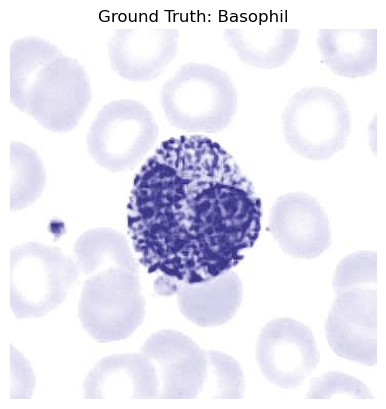

1/1 [==============================] - 0s 425ms/step
 Predicted:
 - Label      : Basophil
 - Cell Shape : round
 - Nucleus    : segmented-bilobed
 - Vacuole    : no

 Ground Truth:
 - Label      : Basophil
 - Cell Shape : round
 - Nucleus    : segmented-bilobed
 - Vacuole    : no


In [46]:
inspect_prediction(eyeball_df, index=8)


In [ ]:
# import pandas as pd
# import os
# import tensorflow as tf

# # Update this with your actual folder containing test images
# IMAGE_FOLDER = "path/to/test_images"
# IMAGE_EXT = ".jpg"  # or ".png"

# # Your output CSV file
# OUT_CSV = "s4076159_predictions.csv"

# # Load your encoders and model
# # These must be defined elsewhere in your notebook or script
# # model, label_encoder, cell_encoder, nuc_encoder, vac_encoder

# def preprocess_image(path):
#     img = tf.io.read_file(path)
#     img = tf.image.decode_jpeg(img, channels=3)
#     img = tf.image.resize(img, TARGET_SIZE)  # must match your training input size
#     img = tf.cast(img, tf.float32) / 255.0
#     return tf.expand_dims(img, axis=0)

# def predict_all(df):
#     predictions = {
#         "label": [],
#         "cell_shape": [],
#         "nucleus_shape": [],
#         "cytoplasm_vacuole": []
#     }

#     for img_id in df['imageID']:
#         img_path = os.path.join(IMAGE_FOLDER, img_id + IMAGE_EXT)
#         if not os.path.exists(img_path):
#             raise FileNotFoundError(f"Image not found: {img_path}")

#         img_tensor = preprocess_image(img_path)
#         pred = model.predict(img_tensor)

#         # Decode each attribute
#         pred_label = label_encoder.inverse_transform([tf.argmax(pred['out_label'][0]).numpy()])[0]
#         pred_cell  = cell_encoder.inverse_transform([tf.argmax(pred['out_cell'][0]).numpy()])[0]
#         pred_nuc   = nuc_encoder.inverse_transform([tf.argmax(pred['out_nuc'][0]).numpy()])[0]
#         pred_vac   = vac_encoder.inverse_transform([tf.argmax(pred['out_vac'][0]).numpy()])[0]

#         # Save predictions
#         predictions["label"].append(pred_label)
#         predictions["cell_shape"].append(pred_cell)
#         predictions["nucleus_shape"].append(pred_nuc)
#         predictions["cytoplasm_vacuole"].append(pred_vac)

#     return predictions

# # Load input CSV (must contain a column 'imageID')
# input_df = pd.read_csv("test_list.csv")

# # Predict
# preds = predict_all(input_df)

# # Add predictions to DataFrame
# input_df["label"] = preds["label"]
# input_df["cell_shape"] = preds["cell_shape"]
# input_df["nucleus_shape"] = preds["nucleus_shape"]
# input_df["cytoplasm_vacuole"] = preds["cytoplasm_vacuole"]

# # Save final predictions
# input_df.to_csv(OUT_CSV, index=False)
# print(f"✅ Saved predictions to {OUT_CSV}")
